In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
data_dir = "/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
indices = list(range(len(full_dataset)))

In [3]:
dataper = [0.01, 0.1, 0.5, 0.7]
accuracies = {
    "test" : []
}
test_acc_per = 0
for i in dataper:
    train_idx, test_idx = train_test_split(indices, train_size=i, random_state=42)
    val_idx, test_idx = train_test_split(test_idx, test_size=0.8, random_state=42)

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)
    test_dataset = Subset(full_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Train set: {len(train_dataset)} images")
    print(f"Validation set: {len(val_dataset)} images")
    print(f"Test set: {len(test_dataset)} images")

    num_classes = 8

    # Load the pretrained MobileNetV2 model
    model = models.mobilenet_v2(pretrained=True)

    # Modify the final fully connected layer to match the number of classes
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training loop with dynamic number of epochs
    def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
        best_acc = 0.0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Training phase
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = correct.double() / len(train_loader.dataset)

            print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    correct += torch.sum(preds == labels.data)
                    total += labels.size(0)

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = correct.double() / len(val_loader.dataset)

            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            # Step scheduler
            scheduler.step()

            # Save the model if validation accuracy improves
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), 'best_mobilenet_v2.pth')
                print(f"Best model saved with accuracy: {best_acc:.4f}")
                train_acc_per = round(epoch_acc.item(), 4)
                val_acc_per = round(val_acc.item(), 4)

    # Example function call with dynamic number of epochs
    train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

    # Evaluate the model on the test dataset
    def test_model(model, test_loader):
        model.load_state_dict(torch.load('best_mobilenet_v2.pth'))
        model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

        test_acc = correct.double() / total
        print(f'Test Accuracy: {test_acc:.4f}')
        return round(test_acc.item(), 4)

    # Test the model
    test_acc_per = test_model(model, test_loader)
    accuracies["test"].append(test_acc_per)
#     accuracies["val"].append(val_acc_per)
#     accuracies["train"].append(train_acc_per)
    
    print(f'Done for {i*100} % data')

Train set: 170 images
Validation set: 3384 images
Test set: 13538 images


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 97.9MB/s]


Epoch 1/10
----------
Train Loss: 1.6184 Acc: 0.3941
Val Loss: 2.3387 Acc: 0.3499
Best model saved with accuracy: 0.3499
Epoch 2/10
----------
Train Loss: 0.7009 Acc: 0.7529
Val Loss: 1.1864 Acc: 0.6410
Best model saved with accuracy: 0.6410
Epoch 3/10
----------
Train Loss: 0.5069 Acc: 0.8176
Val Loss: 0.7922 Acc: 0.7831
Best model saved with accuracy: 0.7831
Epoch 4/10
----------
Train Loss: 0.6797 Acc: 0.7824
Val Loss: 1.0206 Acc: 0.7004
Epoch 5/10
----------
Train Loss: 0.5989 Acc: 0.8000
Val Loss: 1.5251 Acc: 0.6120
Epoch 6/10
----------
Train Loss: 0.4241 Acc: 0.8294
Val Loss: 0.9826 Acc: 0.7411
Epoch 7/10
----------
Train Loss: 0.2895 Acc: 0.9118
Val Loss: 0.7939 Acc: 0.7861
Best model saved with accuracy: 0.7861
Epoch 8/10
----------
Train Loss: 0.2549 Acc: 0.9294
Val Loss: 0.5363 Acc: 0.8342
Best model saved with accuracy: 0.8342
Epoch 9/10
----------
Train Loss: 0.2450 Acc: 0.9353
Val Loss: 0.4494 Acc: 0.8576
Best model saved with accuracy: 0.8576
Epoch 10/10
----------
Train

/tmp/ipykernel_23/308312021.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mobilenet_v2.pth'))


Test Accuracy: 0.8741
Done for 1.0 % data
Train set: 1709 images
Validation set: 3076 images
Test set: 12307 images
Epoch 1/10
----------
Train Loss: 0.6062 Acc: 0.7975
Val Loss: 0.6393 Acc: 0.7955
Best model saved with accuracy: 0.7955
Epoch 2/10
----------
Train Loss: 0.4492 Acc: 0.8578
Val Loss: 0.5666 Acc: 0.8329
Best model saved with accuracy: 0.8329
Epoch 3/10
----------
Train Loss: 0.3266 Acc: 0.8871
Val Loss: 0.6439 Acc: 0.8241
Epoch 4/10
----------
Train Loss: 0.3269 Acc: 0.8800
Val Loss: 0.6487 Acc: 0.8043
Epoch 5/10
----------
Train Loss: 0.3923 Acc: 0.8760
Val Loss: 0.5176 Acc: 0.8368
Best model saved with accuracy: 0.8368
Epoch 6/10
----------
Train Loss: 0.3617 Acc: 0.8800
Val Loss: 0.4112 Acc: 0.8683
Best model saved with accuracy: 0.8683
Epoch 7/10
----------
Train Loss: 0.2468 Acc: 0.9163
Val Loss: 0.3163 Acc: 0.9034
Best model saved with accuracy: 0.9034
Epoch 8/10
----------
Train Loss: 0.1966 Acc: 0.9274
Val Loss: 0.1671 Acc: 0.9499
Best model saved with accuracy: 0

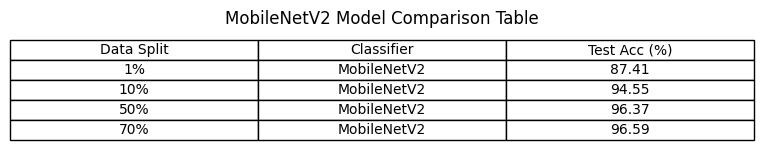

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
data = {
        'Data Split': ['1%', '10%', '50%', '70%'],
        'Classifier': ['MobileNetV2', 'MobileNetV2','MobileNetV2','MobileNetV2'],

        'Test Acc (%)': [accuracies['test'][0]*100, accuracies['test'][1]*100, accuracies['test'][2]*100, accuracies['test'][3]*100]
}

df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(8, 1))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title(f'MobileNetV2 Model Comparison Table', pad=20)
plt.show()